In [1]:
from river import stream,tree,metrics
import utils
import datetime
from encoding import prefix_bin
import csv
import copy
import time

In [2]:
dataset = stream.iter_csv(
            './data/bac_online_small.csv',
            )

totallength = len(list(dataset))

In [3]:
dataset = stream.iter_csv(
            './data/bac_online_small.csv',
            drop=['END_DATE','ROLE','CLOSURE_TYPE','CLOSURE_REASON','WORKING_STATE','case_cost'],
            target='outcome'
            )

**Event stream entry**  
----------  
**Example 1)**  
({'REQUEST_ID': '20175000168',  
  'ACTIVITY': 'Service closure Request with network responsibility',  
  'START_DATE': '2018-10-10 12:48:12.000',  
  'CE_UO': '1'},  
 '')  
   
**Example 2)**  
({'REQUEST_ID': '20175000168',  
  'ACTIVITY': 'Request completed with account closure',  
  'START_DATE': '2018-10-17 03:03:11.000',  
  'CE_UO': 'BOF'},  
 'False')

In [4]:
key_pair = {
        'REQUEST_ID':'caseid',
        'ACTIVITY':'activity',
        'START_DATE':'ts',
        'CE_UO':'resource'
}

case_dict ={}
training_models ={}
feature_matrix ={}
casecount = 0
rowcounter = 0
resultdict ={}
acc_dict ={}
finishedcases = set()
running_case = 0
prediction_result = {}

In [5]:
for x,y in dataset:
    if rowcounter%500 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running case: %s'%(running_case))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
#     x['ts'] = x['ts'][:-4]
    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
#     progress = x['progress']

    x.pop('caseid')
    x.pop('outcome')
#     x.pop('progress')

    case_bin = prefix_bin(caseid, x)

    if caseid not in list(case_dict.keys()):
        case_bin.set_prefix_length(1)    
        case_dict[caseid] = []
        running_case +=1
    elif caseid in finishedcases:
        pass
    else:
        case_bin.set_prefix_length(len(case_dict[caseid])+1)
        case_bin.set_prev_enc(case_dict[caseid][-1])
    
    # Encode event and cases and add to DB
    case_bin.update_truelabel(outcome)   
    case_bin.update_encoded()
    case_dict[caseid].append(case_bin)
    
    # Detect label appeared case 
    if outcome != '' and caseid not in finishedcases:
        finishedcases.add(caseid)
        # Adding newly finished case to training set.    
        casecount +=1
        # Grace period to collect feature matrix
        if casecount <200:
            case_length = len(case_dict[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    training_models['prefix_%s'%(prefix+1)] = [tree.HoeffdingTreeClassifier(grace_period=100,split_criterion='info_gain'),metrics.Accuracy(), 0]
                feature_list = list(case_dict[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            case_dict.pop(caseid)               

        # Real training start
        else:
            # Modify encoded attributes of cases with feature matrix
            case_length = len(case_dict[caseid])
            if case_length >10:
                case_length =10
            y = outcome
            for prefix in range(1, case_length):
                case_dict[caseid][prefix].update_truelabel(y)
                if case_dict[caseid][prefix].grace_updated == False:
                    case_dict[caseid][prefix].encoded = utils.readjustment_training(case_dict[caseid][prefix].encoded, feature_matrix['prefix_%s'%(prefix+1)])
                    case_dict[caseid][prefix].update_grace_status(True)
                x = case_dict[caseid][prefix].encoded
                model = training_models['prefix_%s'%(prefix+1)][0]
                model.learn_one(x,y)
                training_models['prefix_%s'%(prefix+1)][2] +=1
                y_pred = model.predict_one(x)
                training_models['prefix_%s'%(prefix+1)][1].update(y,y_pred)

                for cases in list(case_dict.keys()):
                    if len(case_dict[cases]) >prefix:
                        if case_dict[cases][prefix].grace_updated ==False:
                            case_dict[cases][prefix].encoded = utils.readjustment_training(case_dict[cases][prefix].encoded, feature_matrix['prefix_%s'%(prefix+1)])
                            case_dict[cases][prefix].update_grace_status(True)
                        x_test = case_dict[cases][prefix].encoded
                        y_pred = model.predict_one(x_test)
                        modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(prefix+1)][2]), copy.deepcopy(y_pred)
                        case_dict[cases][prefix].update_prediction((modelid, pred_value))
                        prediction_key = str(cases)+'_'+str(prefix+1)
                        if str(cases)+'_'+str(prefix+2) not in prediction_result.keys():
                            if prediction_key not in prediction_result.keys():
                                prediction_result[prediction_key] = {}
                                prediction_result[prediction_key][modelid] = (pred_value,time.time())
                            else:
                                prediction_result[prediction_key][modelid] = (pred_value,time.time())
            copying = copy.deepcopy(case_dict[caseid])
            resultdict[caseid] = copying
            case_dict[caseid] =[]
            running_case -=1
            for prefix in training_models.keys():
                if prefix not in list(acc_dict.keys()):
                    acc_dict[prefix]=[training_models[prefix][1].get()]
                else:
                    acc_dict[prefix].append(training_models[prefix][1].get())


0.0 % Case finished: 0 Running case: 0
1.64 % Case finished: 1 Running case: 166
3.29 % Case finished: 1 Running case: 319
4.93 % Case finished: 1 Running case: 437
6.57 % Case finished: 39 Running case: 547
8.21 % Case finished: 49 Running case: 597
9.86 % Case finished: 203 Running case: 631
11.5 % Case finished: 292 Running case: 610
13.14 % Case finished: 386 Running case: 590
14.79 % Case finished: 474 Running case: 575
16.43 % Case finished: 572 Running case: 538
18.07 % Case finished: 648 Running case: 531
19.72 % Case finished: 755 Running case: 510
21.36 % Case finished: 769 Running case: 613
23.0 % Case finished: 794 Running case: 659
24.64 % Case finished: 896 Running case: 612
26.29 % Case finished: 1016 Running case: 543
27.93 % Case finished: 1076 Running case: 567
29.57 % Case finished: 1134 Running case: 581
31.22 % Case finished: 1233 Running case: 530
32.86 % Case finished: 1361 Running case: 457
34.5 % Case finished: 1434 Running case: 450
36.14 % Case finished: 1507

In [6]:
for prefix in acc_dict.keys():
    print(acc_dict[prefix])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9629629629629629, 0.9285714285714286, 0.9310344827586207, 0.9333333333333333, 0.9354838709677419, 0.90625, 0.9090909090909091, 0.9117647058823529, 0.9142857142857143, 0.9166666666666666, 0.918918918918919, 0.9210526315789473, 0.9230769230769231, 0.9, 0.9024390243902439, 0.9047619047619048, 0.9069767441860465, 0.8863636363636364, 0.8888888888888888, 0.8913043478260869, 0.8936170212765957, 0.8958333333333334, 0.8979591836734694, 0.9, 0.9019607843137255, 0.9038461538461539, 0.9056603773584906, 0.9074074074074074, 0.9090909090909091, 0.9107142857142857, 0.9122807017543859, 0.9137931034482759, 0.9152542372881356, 0.9166666666666666, 0.9180327868852459, 0.9193548387096774, 0.9206349206349206, 0.921875, 0.9230769230769231, 0.9242424242424242, 0.9253731343283582, 0.9264705882352942, 0.927536231884058, 0.9285714285714286, 0.9295774647887324, 0.9305555555555556, 0.

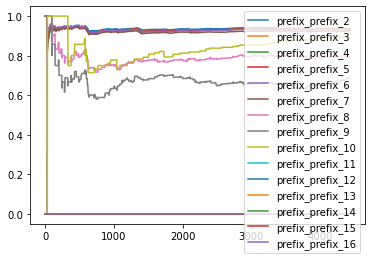

In [7]:
import matplotlib.pyplot as plt
for prefix in acc_dict.keys():
    plt.plot(range(len(acc_dict[prefix])), acc_dict[prefix],label='prefix_%s'%(prefix))
plt.legend()
plt.show()